In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['glove840b300dtxt', 'jigsaw-toxic-comment-classification-challenge']


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import re
import math
import pickle
import seaborn as sns
from time import time

import tensorflow as tf

In [6]:
NUM_EPOCHS = 10
NUM_WORDS = 50000

MODEL_NAME = 'toxicity'

BEST_WEIGHTS = ('{}_glove_best_weights.hdf5'.format(MODEL_NAME))
MODEL_FILE = ('{}_glove_model.h5'.format(MODEL_NAME))

In [4]:
def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

In [7]:
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


def load_dataset():
    df1 = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
    print(df1.shape)
    
    df2 = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')
    df3 = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
    df4 = pd.merge(df2, df3, on='id')
    print(df4.shape)
    
    df = pd.concat([df1, df4], ignore_index=True)
    df['text'] = df['comment_text'].apply(lambda x: process_text(x))

    tokenizer = Tokenizer(num_words = NUM_WORDS, split = ' ')
    tokenizer.fit_on_texts(df['text'].values)

    X = tokenizer.texts_to_sequences(df['text'].values)
    X = pad_sequences(X, maxlen=50)
    
    df['X'] = pd.Series(list(X))
    
    df.loc[df.toxic == -1, 'toxic'] = 0
    df.loc[df.severe_toxic == -1, 'severe_toxic'] = 0
    df.loc[df.obscene == -1, 'obscene'] = 0
    df.loc[df.threat == -1, 'threat'] = 0
    df.loc[df.insult == -1, 'insult'] = 0
    df.loc[df.identity_hate == -1, 'identity_hate'] = 0
    
    df_train = df.iloc[: df1.shape[0]]
    df_test= df.iloc[df1.shape[0] :]

    df_train, df_val = train_test_split(df_train, test_size=0.02, random_state=1)
    return df_train, df_val, df_test, tokenizer


df_train, df_val, df_test, tokenizer = load_dataset()

X_train = np.asarray(df_train['X'].tolist())
X_val = np.asarray(df_val['X'].tolist())
X_test = np.asarray(df_test['X'].tolist())

Y_train = np.asarray(df_train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values)
Y_val = np.asarray(df_val[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values)
Y_test = np.asarray(df_test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values)
  
    
print("Train shape: {} - {}".format(X_train.shape, Y_train.shape))
print("Val shape: {} - {}".format(X_val.shape, Y_val.shape))
print("Test shape: {} - {}".format(X_test.shape, Y_test.shape))
# print(X_train[: 1])
# print(Y_train[: 3])
# print(tokenizer.word_index["the"])

(159571, 8)
(153164, 8)
Train shape: (156379, 50) - (156379, 6)
Val shape: (3192, 50) - (3192, 6)
Test shape: (153164, 50) - (153164, 6)


In [ ]:
# Saving tokenizer
# with open('../model/{}_glove_tokenizer.pickle'.format(MODEL_NAME), 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
def load_vectors(file, total_num):
    word_vec = {}
    
    with open(file, encoding='utf-8', mode = 'r') as f:
        # lines = f.read().splitlines() # MemoryError

        count = 0
        # for i in range(0, len(lines)):
        #     values = lines[i].strip().split()
        for line in f:
            values = line.strip().split()
            curr_word = values[0]

            try:
                word_vec[curr_word] = np.array(values[1:], dtype=np.float64)

                count += 1
                if count % 1000 == 0:
                    print('Processed {0} of {1}'.format(count, total_num), end='\r')

            # except Exception as ex:
            #     template = "An exception of type {0} occurred. Arguments:\n{1!r}"
            #     message = template.format(type(ex).__name__, ex.args)
            #     print(message)
            except ValueError: # For data errors
                # print("ValueError - ", curr_word)
                pass

        print('Processed {0} of {1}'.format(count, total_num))
    return word_vec

word_vec = load_vectors('../input/glove840b300dtxt/glove.840B.300d.txt', 2195997)

Processed 2195998 of 2195997


In [11]:
import keras.layers as layers
import keras.backend as K
from keras.models import Model


def pretrained_embedding_layer(word_vec, word_index):
    vocab_len = len(word_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_vec["the"].shape[0]  # define dimensionality of your GloVe word vectors (= 50 or 100)

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = layers.Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_index.items():
        vec = word_vec.get(word)
        if vec is not None:
            emb_matrix[index, :] = vec

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer


def create_model(input_shape, out_shape, activation, word_vec, word_index):
    # Define input sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    inputs = layers.Input(input_shape, dtype="int32")

    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_vec, word_index)
    # Propagate input sentence_indices through your embedding layer, you get back the embeddings
    X = embedding_layer(inputs)
        
    # Add dropout with a probability
    X = layers.SpatialDropout1D(0.3)(X)

    # Propagate the embeddings through an LSTM layer with dimensional hidden state
    X = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat')(X)
    X = layers.Dropout(0.3)(X)

    # Propagate X trough another LSTM layer with dimensional hidden state
    X = layers.Bidirectional(layers.LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), merge_mode='concat')(X)
    X = layers.Dropout(0.3)(X)

    X = layers.Dense(512, activation='relu')(X)
    X = layers.Dropout(0.3)(X)

    outputs = layers.Dense(out_shape, activation=activation)(X)

    # Create Model instance which converts input sentence_indices into X.
    model = Model(inputs=inputs, outputs=outputs)

    return model


model = create_model((X_train.shape[1], ), 6, 'sigmoid', word_vec, tokenizer.word_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           84622200  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 512)           1140736   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
__________

In [12]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

In [13]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class ROC_AUC(Callback):
    def __init__(self, X, Y, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X, self.Y = X, Y

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            Y_pred = self.model.predict(self.X, verbose=0)
            score = roc_auc_score(self.Y, Y_pred)
            print("ROC AUC score: {:.6f}".format(score))

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath=BEST_WEIGHTS, verbose=1, save_best_only=True)   # Save the best model
tensorboard = TensorBoard(log_dir='logs/{} - {}'.format(MODEL_NAME, time()))
roc_auc = ROC_AUC(X_val, Y_val)

hist = model.fit(X_train,
                 Y_train,
                 batch_size = 32, 
                 epochs = NUM_EPOCHS, 
                 verbose=1, 
                 callbacks=[monitor, checkpoint, tensorboard, roc_auc],
                 validation_data=(X_val, Y_val),
                 validation_split=0.02,
                 shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 156379 samples, validate on 3192 samples
Epoch 1/2
156379/156379 [==============================] - 2043s 13ms/step - loss: 0.0719 - acc: 0.9763 - val_loss: 0.0595 - val_acc: 0.9782

Epoch 00001: val_loss improved from inf to 0.05946, saving model to toxicity_glove_best_weights.hdf5
ROC AUC score: 0.973198
Epoch 2/2
156379/156379 [==============================] - 2009s 13ms/step - loss: 0.0565 - acc: 0.9801 - val_loss: 0.0531 - val_acc: 0.9796

Epoch 00002: val_loss improved from 0.05946 to 0.05309, saving model to toxicity_glove_best_weights.hdf5
ROC AUC score: 0.981107


In [15]:
model.load_weights(BEST_WEIGHTS)
model.save(MODEL_FILE)
    
# from keras.models import load_model
# model = load_model(MODEL_FILE)

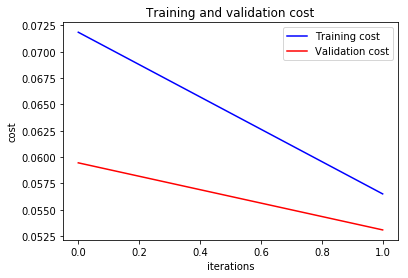

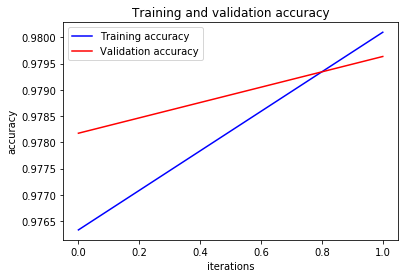

In [16]:
def plot_train_history(history):
    # plot the cost and accuracy 
    loss_list = history['loss']
    val_loss_list = history['val_loss']
    accuracy_list = history['acc']
    val_accuracy_list = history['val_acc']
    # epochs = range(len(loss_list))

    # plot the cost
    plt.plot(loss_list, 'b', label='Training cost')
    plt.plot(val_loss_list, 'r', label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('Training and validation cost')
    plt.legend()
    
    plt.figure()
    
    # plot the accuracy
    plt.plot(accuracy_list, 'b', label='Training accuracy')
    plt.plot(val_accuracy_list, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iterations')
    plt.title('Training and validation accuracy')
    plt.legend()

    

plot_train_history(hist.history)

In [17]:
score = model.evaluate(X_test, Y_test)

print ("Test Loss = " + str(score[0]))
print ("Test Accuracy = " + str(score[1]))

153164/153164 [==============================] - 840s 5ms/step
Test Loss = 0.14557909445603112
Test Accuracy = 0.9417530573708575


In [18]:
Y_test_pred = model.predict(X_test, batch_size=32, verbose=1)

153164/153164 [==============================] - 831s 5ms/step


AUC:  0.8893605395029965
      threshold       fpr     1-fpr       tpr      diff
8614   0.401734  0.180712  0.819288  0.819212 -0.000076
AUC:  0.9717384995807246
     threshold       fpr     1-fpr       tpr      diff
901   0.042112  0.076788  0.923212  0.923706  0.000494
AUC:  0.9214599571677133
      threshold       fpr     1-fpr       tpr      diff
5660   0.178036  0.145364  0.854636  0.854511 -0.000125
AUC:  0.9555339506919744
     threshold       fpr     1-fpr       tpr      diff
782   0.014747  0.097115  0.902885  0.905213  0.002328
AUC:  0.9158571490405357
      threshold       fpr     1-fpr       tpr      diff
5306   0.203968  0.158318  0.841682  0.841844  0.000162
AUC:  0.9476526429980392
      threshold       fpr     1-fpr       tpr      diff
1620   0.038807  0.122629  0.877371  0.877809  0.000438


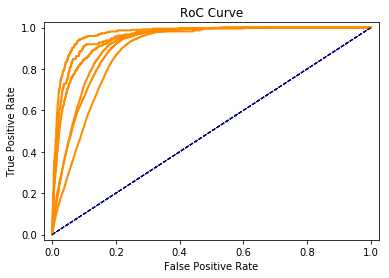

In [19]:
from sklearn.metrics import roc_curve, auc

def calculate_optimal_threshold(Y, Y_pred):
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(Y, Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    print("AUC: ", roc_auc)
    
    # Calculate the optimal threshold
    i = np.arange(len(tpr)) # index for df
    roc_df = pd.DataFrame({'threshold' : pd.Series(thresholds, index = i), 
                           'fpr': pd.Series(fpr, index=i), 
                           '1-fpr' : pd.Series(1-fpr, index = i), 
                           'tpr': pd.Series(tpr, index = i), 
                           'diff': pd.Series(tpr - (1-fpr), index = i) })
    opt_threshold = roc_df.iloc[roc_df['diff'].abs().argsort()[:1]]
    print(opt_threshold)
    
    return opt_threshold['threshold'].values[0]
    
    
threshold0 = calculate_optimal_threshold(Y_test[:, 0], Y_test_pred[:, 0])
threshold1 = calculate_optimal_threshold(Y_test[:, 1], Y_test_pred[:, 1])
threshold2 = calculate_optimal_threshold(Y_test[:, 2], Y_test_pred[:, 2])
threshold3 = calculate_optimal_threshold(Y_test[:, 3], Y_test_pred[:, 3])
threshold4 = calculate_optimal_threshold(Y_test[:, 4], Y_test_pred[:, 4])
threshold5 = calculate_optimal_threshold(Y_test[:, 5], Y_test_pred[:, 5])

Accuracy Score: 0.819278681674545

RMSE Score: 0.3494897110386802

Confusion Matrix:
[[120496  26578]
 [  1102   4988]]
Classification Report:
              precision    recall  f1-score   support

        True       0.99      0.82      0.90    147074
       False       0.16      0.82      0.26      6090

   micro avg       0.82      0.82      0.82    153164
   macro avg       0.57      0.82      0.58    153164
weighted avg       0.96      0.82      0.87    153164



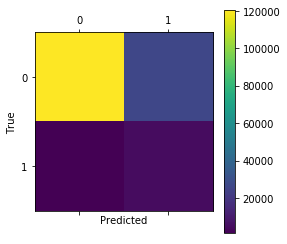

In [21]:
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report

def analyze(Y, Y_pred, classes, activation="softmax", threshold=None):
    if activation == "sigmoid":
        Y_cls = Y
        Y_pred_cls = (Y_pred > threshold).astype(float)
    elif activation == "softmax":
        Y_cls = np.argmax(Y, axis=1)
        Y_pred_cls = np.argmax(Y_pred, axis=1)
    
    
    # Accuracy Score
    accuracy = accuracy_score(Y_cls, Y_pred_cls)
    print("Accuracy Score: {}\n".format(accuracy))
    
    
    # RMSE Score
    rmse = np.sqrt(mean_squared_error(Y, Y_pred))
    print("RMSE Score: {}\n".format(rmse))

    
    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(Y_cls, Y_pred_cls)
    print(cm)
    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    # Make various adjustments to the plot.
    num_classes = len(classes)
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(Y_cls, Y_pred_cls, target_names=classes))



analyze(Y_test[:, 0], Y_test_pred[:, 0], ['True', 'False'], "sigmoid", threshold0)

In [ ]:
submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = Y_test_pred
submission.to_csv('submission.csv', index=False)